<a href="https://colab.research.google.com/github/burcia1711/word-order-simulation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTS AND OTHER FUNCTIONALITIES**

In [1]:
import random
from copy import deepcopy 
from numpy.random import normal
import numpy
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')



# **constants**

In [2]:
personalities = ['F', 'S'] #F for flexible, S for stubborn

sentence_type = ['reversible', 'irreversible']
sentence_weights = [7, 3]

basic_orders = ['SOV', 'SVO', 'OSV', 'OVS', 'VSO', 'VOS']

start = 0
stop = 2



## **LANGUAGE**

There are different types of languages (logical, agglutinative, etc.). So, if a languagua evolve one of them, then there will be consequences accordingly.


In [ ]:
class Language:
  def __init__(self, typ, age, pop):
    self.typ = typ
    self.age = age
    self.population = pop

## general functions / utils

In [10]:
#Functions about stubborn people
def set_irrev_stubborn():
  return [7, 10, 1, 1, 1, 1]

def set_rev_stubborn():
  return [7, 10, 1, 1, 1, 1]

def calculate_irrev_stubborn():
  return [7, 10, 1, 1, 1, 1]

def calculate_rev_stubborn():
  return [7, 10, 1, 1, 1, 1]

#Functions about flexible people
def calculate_irrev_flexible():
  return [7, 10, 1, 1, 1, 1]

def calculate_rev_flexible():
  return [7, 10, 1, 1, 1, 1]

def calculate_irrev_flexible():
  return [7, 10, 1, 1, 1, 1]

def calculate_rev_flexible():
  return [7, 10, 1, 1, 1, 1]

## **AGENTS**

Agents are humans, they have:

*   generation number (1st, 2nd, 10th, etc.) 
*   personality type (stubborn or flexible)
*   is affected by any other languge (1 is for True, 0 is for False)



In [13]:
class Agent:

  def __init__(self, g, p, l):
    self.generation = g
    self.personality = p
    self.ling = l
    self.irrev_weights =[]
    self.rev_weights =[]

    self.set_irrev_weights()
    self.set_rev_weights()
    self.add_irrev_weights()
    self.add_rev_weights()

  def is_stubborn(self):
    return self.personality == 'S'
  
  def set_irrev_weights(self):
    if(self.is_stubborn()):
      self.irrev_weights = set_irrev_stubborn()
    else:
      self.irrev_weights = set_irrev_flexible()

  def set_rev_weights(self):
    if(self.is_stubborn()):
      self.rev_weights = set_rev_stubborn()
    else:
      self.rev_weights = set_rev_flexible()

  def add_rev_weights(self):
    if(self.is_stubborn()):
      self.rev_weights = calculate_rev_stubborn()
    else:
      self.rev_weights = calculate_rev_flexible()

  def add_irrev_weights(self):
    if(self.is_stubborn()):
      self.irrev_weights = calculate_irrev_stubborn()
    else:
      self.irrev_weights = calculate_irrev_flexible()

In [14]:
#create agents (humans :D)
def make_agent(agent):
    return [agent.generation, agent.personality, agent.ling, agent.irrev_weights, agent.rev_weights]

## **POPULATIONS**

Populations are based on number of people (N) in a particular generation

In [45]:
def make_agents(N, G):
    gen = G
    population = []

    for i in range(N): 
        l = random.randint(0,1)
        p = random.randint(0,1)
        agent = Agent(gen, personalities[p], l)
        population.append(agent)

    for obj in population:
      print(obj.rev_weights)

    return population


# Check that this works by making a population of 8 agents

make_agents(8,0)


[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]


In [46]:
def create_population(starting_pop, n_generations):
  people_in_population = []
  for i in range(n_generations): 
    if i == 0:
      people_in_population.extend(make_agents(starting_pop, i))
    else:
      people_in_population.extend(make_agents(int(len(people_in_population)*(random.randrange(start, stop+1)+0.3)), i))
    print(len(people_in_population))

  return(people_in_population)
    
population_test = create_population(5, 1)
  

[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
[7, 10, 1, 1, 1, 1]
5


In [47]:
print(population_test)

[<__main__.Agent object at 0x7f603a3ead90>, <__main__.Agent object at 0x7f6031828f90>, <__main__.Agent object at 0x7f6031828550>, <__main__.Agent object at 0x7f6031828910>, <__main__.Agent object at 0x7f60318283d0>]


## **WORD ORDER and SENTENCE GENERATION**



In [17]:
from collections import Counter
import pandas

def plot_freq_list(l):
  count = Counter(sorted(l))
  df = pandas.DataFrame.from_dict(count, orient='index')
  df.plot(kind='bar')


In [18]:
def generate_word_order_list(order_list, weight, n):
  return random.choices(order_list, weights = weight, k = n)

In [19]:
WORD_ORDER_LIST = []

WORD_ORDER_LIST = generate_word_order_list(basic_orders,[10, 7, 1, 1, 1, 1], 100)
WORD_ORDER_LIST

['SVO',
 'SVO',
 'SVO',
 'SOV',
 'VOS',
 'SVO',
 'OSV',
 'SOV',
 'SOV',
 'SOV',
 'SVO',
 'SOV',
 'OSV',
 'SVO',
 'SOV',
 'SOV',
 'SOV',
 'SVO',
 'SOV',
 'SOV',
 'SOV',
 'SVO',
 'OVS',
 'SOV',
 'SOV',
 'SOV',
 'SOV',
 'VSO',
 'SOV',
 'SVO',
 'SOV',
 'SVO',
 'SVO',
 'SVO',
 'SOV',
 'SOV',
 'SOV',
 'OVS',
 'SOV',
 'SVO',
 'VOS',
 'SVO',
 'SOV',
 'SVO',
 'SOV',
 'SOV',
 'SOV',
 'SVO',
 'SVO',
 'SOV',
 'SOV',
 'SVO',
 'SOV',
 'SVO',
 'OSV',
 'SOV',
 'SOV',
 'SVO',
 'VOS',
 'SVO',
 'SOV',
 'SVO',
 'SOV',
 'SVO',
 'OSV',
 'SVO',
 'SOV',
 'OSV',
 'SOV',
 'SOV',
 'SOV',
 'SOV',
 'SOV',
 'SOV',
 'SVO',
 'SOV',
 'SOV',
 'VOS',
 'SOV',
 'SOV',
 'SVO',
 'OSV',
 'VOS',
 'OVS',
 'OSV',
 'VSO',
 'SOV',
 'VOS',
 'VSO',
 'SOV',
 'SOV',
 'OSV',
 'SOV',
 'SVO',
 'SVO',
 'SOV',
 'SOV',
 'VOS',
 'OVS',
 'SOV']

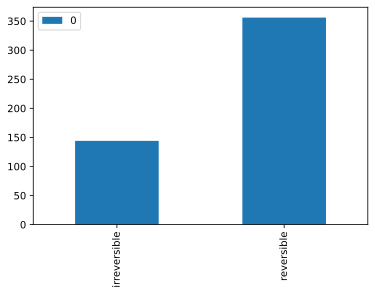

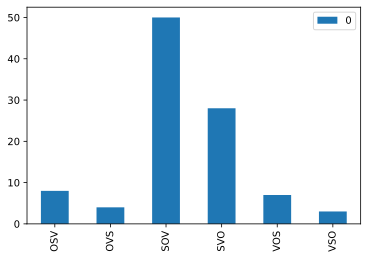

In [20]:
def make_utterance(n):
  return random.choices(sentence_type, weights =sentence_weights, k = n)

utterence_list =[] 
utterence_list = make_utterance(500)

plot_freq_list(utterence_list)
plot_freq_list(WORD_ORDER_LIST)

# **COMMUNICATIONS**

In [52]:
#two people communicate with n sentences
def two_people_communicate(n, population):  #n sentence number, population is the given population
  sentence_list = make_utterance(n)
  people_selected = []
  
  agent1_index = random.randint(0, len(population)-1)
  agent2_index = random.randint(0, len(population)-1)

  while agent1_index == agent2_index:
    agent2_index = random.randint(0, len(population))

  print(agent1_index)
  print(agent2_index)

  people_selected.append(population[agent1_index])
  people_selected.append(population[agent2_index])

  #print(people_selected, sentence_list)

  for i in range(n):
    speaker_index = random.randint(0, 1)
    if sentence_list[i] == 'irrev':
      print(generate_word_order_list(basic_orders, population[speaker_index].irrev_weights, 1))
      #update listener
      
    else:
      print(generate_word_order_list(basic_orders, population[speaker_index].rev_weights, 1))
      #update listener



In [53]:
two_people_communicate(25, population_test)

4
2
['SOV']
['SVO']
['SVO']
['OVS']
['SOV']
['OSV']
['SOV']
['VOS']
['SVO']
['SOV']
['SVO']
['SVO']
['VOS']
['SVO']
['SOV']
['OSV']
['SOV']
['OVS']
['SVO']
['SOV']
['SOV']
['SVO']
['OVS']
['SOV']
['SOV']


## Network types



*   **Vertical network** (1-1 communication)
*   **Circular** (1-1 but circular & continuous)
*   **Chain** (like vertical but many go on)
*   **Wheel** (a center, others communicate with that center simultaneously)
*   **Star** (all connected & comunicate simultaneously)




# **SIMULATIONS**

**Parameters:**


*   Different networks
*   Different frequencies of utterance creation (communication)
*   Size of population
*   Different language types
*   Different starting bias
*   Number of generations



In [ ]:
# def choose_utterance(agent):   # sample from a normal distribution with SD=0.25 and mean of the teacher
#    agent_utterance=normal(agent[0],.25)
#    return agent_utterance

# Let's check that this works
# You can run this multiple times to see different chosen utterances for different agents

# pop=make_population(4)
# vowel = choose_utterance(pop[0])
# print("The agent's mean was", pop[0][0])
# print("The agent's chosen utterance is", vowel)